In [1]:
%run ../startup.py

INFO:root:/home/stites/git/combinators appended to python path
INFO:root:%load_ext autoreload
INFO:root:%autoreload 2
INFO:root:from IPython.core.debugger import set_trace
INFO:root:from IPython.core.display import display, HTML
INFO:root:import torch
INFO:root:import numpy as np
INFO:root:import scipy as sp
INFO:root:import matplotlib
INFO:root:import matplotlib.pyplot as plt
INFO:root:%matplotlib inline
INFO:root:import seaborn as sns
INFO:root:import pandas as pd


In [2]:
import torch
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from main import nvi_declarative, test, plot_sample_hist, mk_model
from combinators.utils import load_models, models_as_dict
from combinators.objectives import nvo_avo, nvo_rkl
from tqdm import tqdm
%matplotlib inline

In [3]:
directory = "./sync/weights"
models = dict()

from tabulate_and_plot import all_file_prefixes, from_file_prefix
from combinators.utils import models_as_dict

models = dict()
for prefix in all_file_prefixes():
    models[prefix] = []
    for file in os.listdir(directory):
        if file.startswith(prefix) and 'metric-tuple' not in file and file.endswith('pt'):
            keyspec = from_file_prefix(prefix)
            model = mk_model(keyspec.num_targets, optimize_path=keyspec.optimize_path)
            load_models(
                models_as_dict(model, ["targets", "forwards", "reverses"]),
                filename=file,
                weights_dir=directory)
            models[prefix].append((file, model, keyspec.objective))
    if len(models[prefix]) == 0:
        del models[prefix]


/nix/store/1fw9h2capcs2dpc7pgc39pn3g0zwm078-python3-3.8.6-env/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
amodel = next(iter(models.values()))[0][1]
proposal0 = amodel[0][0]
target = amodel[0][-1]
print("From:", proposal0)
print("To  :", target)

sample_shape = (50000, 1)
g0_out = proposal0(None, batch_dim=1, sample_dims=0, sample_shape=sample_shape)
samples_g0 = g0_out.output['g0']

_, samples_baseline = target.sample(sample_shape=sample_shape)

From: Distribution[name=g0; dist=MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2]))]
To  : [g1]RingGMM()


In [5]:
sample_dict = dict()
item = 0

# ==================================== #
for k, smodels in tqdm(models.items(), total=len(models)):
    (file, model, objective) = smodels[0]
    keyspec = from_file_prefix(k)
    if keyspec.num_targets == 8:
        runner = nvi_declarative(*model, loss_fn=objective, resample=keyspec.resample)
        _,_,_, samples, out = test(runner, sample_shape, batch_dim=1, sample_dims=0, _debug=True)
        sample_dict[k] = [("g0", samples_g0)] + samples + [("p", samples_baseline)]
sample_dict = {k: list(map(lambda x: x[1], xs)) for k, xs in sample_dict.items()}

100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


In [6]:
keys = set(sample_dict.keys())
sortedkeys = [
    'nvi_nvo_avo_S288_K8_I20000',
    'nvi_nvo_rkl_S288_K8_I20000',
    'nvir_nvo_rkl_S288_K8_I20000',
    'nvis_nvo_rkl_S288_K8_I20000',
    'nvirs_nvo_rkl_S288_K8_I20000'
]
assert keys == set(sortedkeys)

# unnessecary in python 3.7+, but might as well not assume keys are in the dict until the last possible moment ¯\_(ツ)_/¯
from collections import OrderedDict
ordered_sample_dict = OrderedDict()
for k in sortedkeys:
    ordered_sample_dict[k] = sample_dict[k]

In [21]:
filename = 'annealing-arxiv.svg'
M=len(ordered_sample_dict)+1
K=len(next(iter(ordered_sample_dict.values())))+1

if not os.path.exists("./figures/"):
    os.makedirs("./figures/")

def mklabel(i):
    if i < 8:
        return "$c$         q_{}($c'$)".format(i+1)
    else:
        return "$c$         target($c'$)"

select = lambda k, i: (mklabel(i), ordered_sample_dict[k][i])

100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


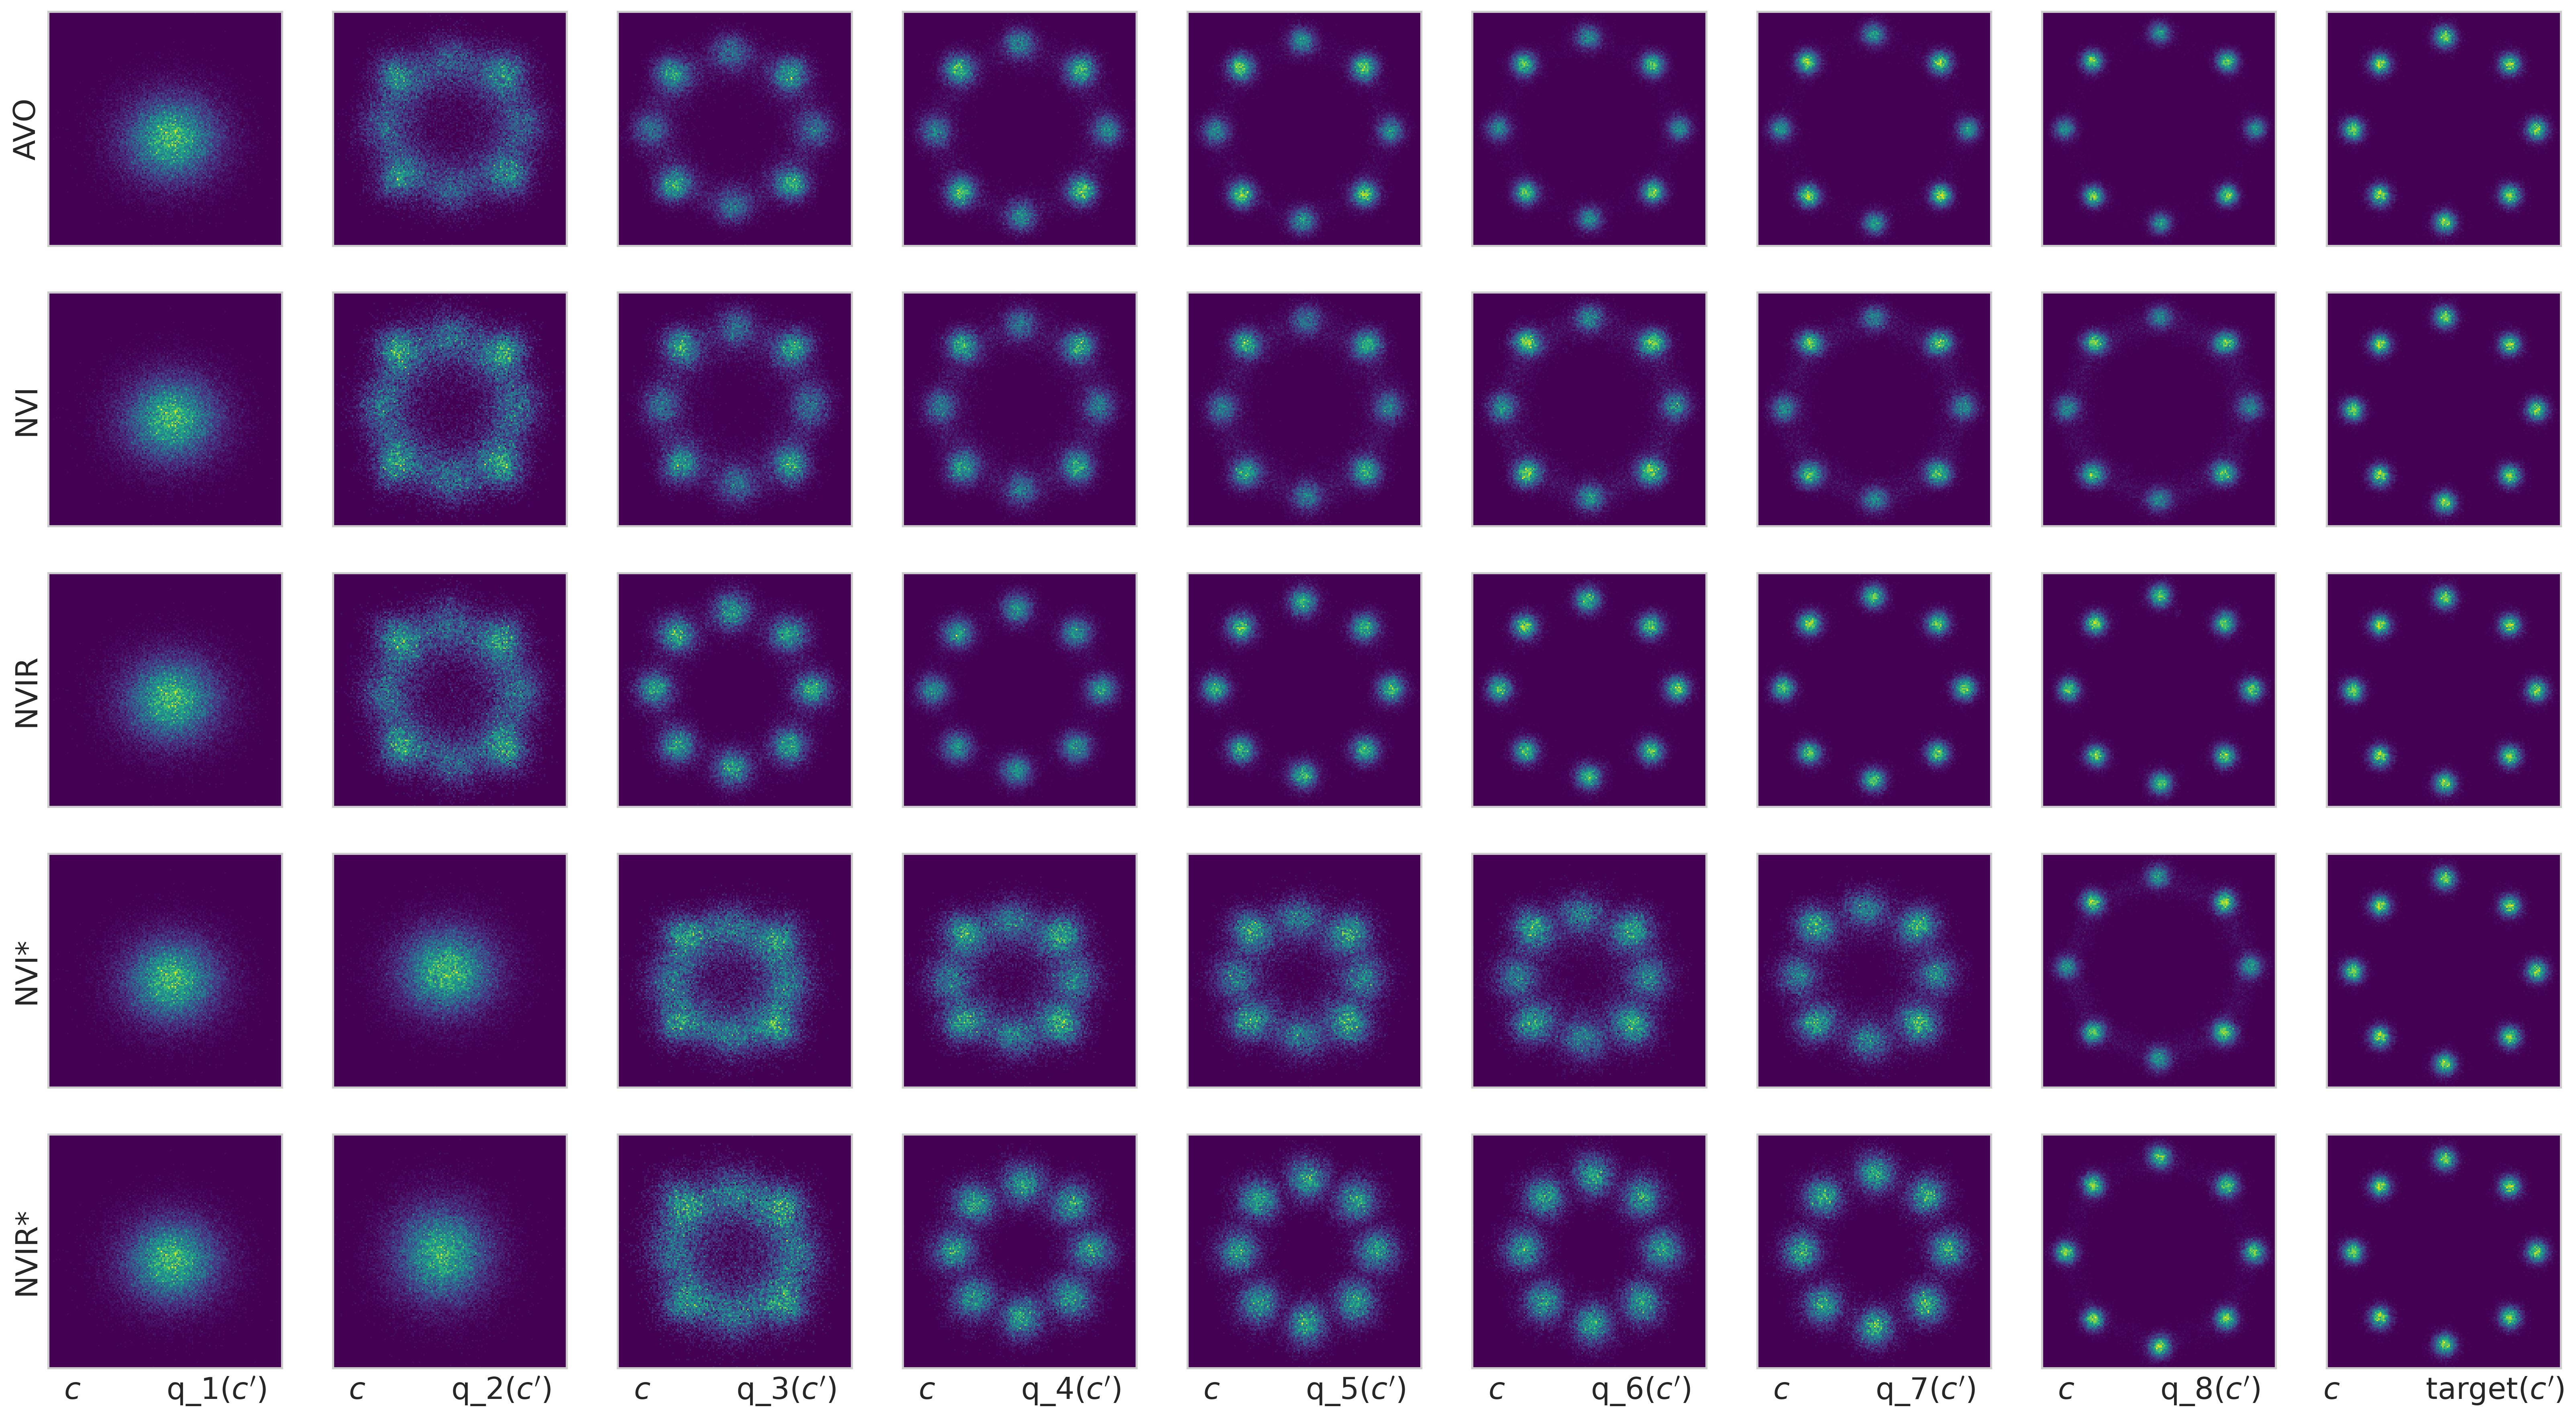

In [22]:
fig = plt.figure(figsize=(3*K, 3*M), dpi=300)

for m, key in tqdm(enumerate(sortedkeys), total=len(sortedkeys)):
    for k in range(K-1):
        ax = fig.add_subplot(M, K, (k+1)+K*m)
        ax.tick_params(bottom=False, top=False, left=False, right=False,
                       labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        ax.grid(False)
        label, X = select(key, k)
        if m == M-2:
            ax.set_xlabel(label, fontsize=18)
        if k == 0:
            keyspec = from_file_prefix(key)
            ylabel = "NVI"
            if keyspec.objective.__name__ == "nvo_avo":
                ylabel = "AVO"
            if keyspec.resample:
                ylabel += "R"
            if keyspec.optimize_path:
                ylabel += "*"
            ax.set_ylabel(ylabel, fontsize=18)
        plot_sample_hist(ax, X, bins=150, cmap='viridis')

fig.savefig("figures/{}".format(filename), bbox_inches='tight')